<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/notebooks/00_Stationarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stationarity(정상성)

# 시계열의 정상성(Stationarity) 요약

- **정상성(약 정상성 / covariance stationarity)**  
  평균과 분산이 시간에 따라 **상수**이고, 공분산은 **시차(라그)** 에만 의존.
  
  $$E[X_t]=\mu,\quad Var(X_t)=\sigma^2,\quad Cov(X_t, X_{t-k}) = \gamma(k)$$
  

- **강 정상성(Strict stationarity)**  
  모든 시점·모든 차원에서 **결합분포**가 시간 이동에 대해 불변.

- **정상 vs 비정상 예시**
  - 정상: AR(1) $$(X_t=\phi X_{t-1}+\varepsilon_t,\ |\phi|<1)$$
  - 비정상: Random walk $$(X_t=X_{t-1}+\varepsilon_t)$$

- **검정**
  - **ADF**: H0=단위근(비정상). p가 작으면 정상성 채택.
  - **KPSS**: H0=정상성. p가 크면 정상성 유지(기각 못함).

- **등분산성(Homoscedasticity)**  
  잔차 분산이 일정. 시계열 분석에선 정상성과 함께 자주 점검.

## 1) 라이브러리/환경

* `yfinance`, `pandas`, `numpy`: 데이터 다운로드/전처리
* `matplotlib`: 시각화
* `statsmodels`: ACF/PACF, ADF/KPSS, Ljung–Box 등 통계 검정
* `warnings.filterwarnings("ignore")`: 시끄러운 경고 억제

## 1) 데이터 다운로드 & 인덱스 정리

* `yf.download("TSLA", start, end, auto_adjust=True)[["Close"]]`

  * 조정종가만 가져옵니다.
  * `auto_adjust=True`라 배당/분할이 반영된 연속적인 종가입니다.
* `px.index = pd.to_datetime(px.index)`

  * 인덱스를 DatetimeIndex로 맞춰 시계열 연산에 대비합니다.

## 1) “Close”를 Series로 강제 변환 (rename 에러 방지)

* 문제 원인: 일부 환경에서 `px["Close"]`가 **DataFrame**으로 남아 `rename("price")`가 함수로 오해됨.
* 해결 코드:

  ```python
  close_obj = px["Close"]
  y_price = (close_obj.squeeze("columns") if isinstance(close_obj, pd.DataFrame) else close_obj).astype(float)
  y_price.name = "price"
  ```

  * `squeeze("columns")`로 **반드시 Series**로 만들고 `.name`으로 시리즈 이름 지정.

## 1) 로그 변환 & 수익률

* `y_log = np.log(y_price)` : 가격의 승법적 변동을 덜 왜곡(분산 안정화)하기 위해 로그 사용.
* `ret = y_log.diff().dropna()` : 로그차분 = 근사 연속복리 수익률(정상성 가정이 더 현실적).

[*********************100%***********************]  1 of 1 completed


TSLA: 1952 obs | 2018-01-02 ~ 2025-10-07
TSLA Price (non-stationary 가능성 높음)
TSLA Log Return (대체로 stationary))


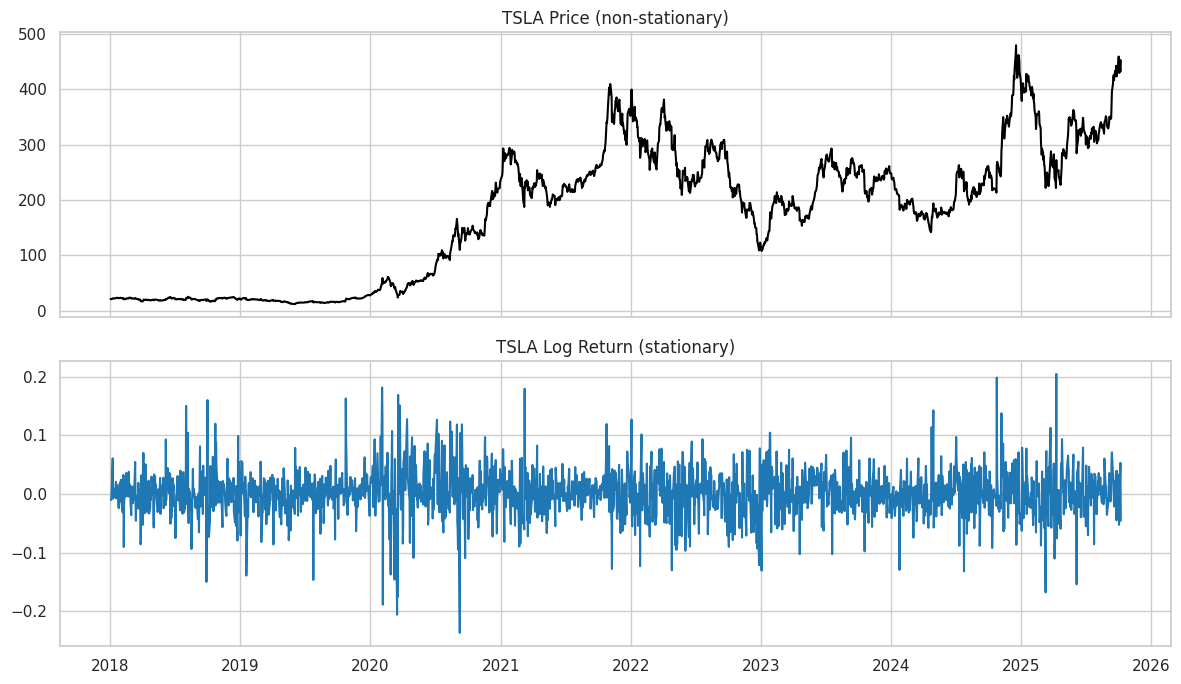

In [19]:
# ===============================
# Stationarity playground (TSLA)
# ===============================
# %pip -q install yfinance statsmodels seaborn matplotlib

import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,4)


# -------------------------------
# 1) 데이터: TSLA 일별 종가, 로그수익률
# -------------------------------
symbol = "TSLA"
start  = "2018-01-01"
end    = None  # 오늘까지

px = yf.download(symbol, start=start, end=end, auto_adjust=True)[["Close"]].dropna()
px.index = pd.to_datetime(px.index)
y_price = px.loc[:, "Close"].squeeze("columns").astype(float); y_price.name = "price"

y_log   = np.log(y_price).rename("log_price")
ret     = y_log.diff().dropna().rename("log_return")  # ~ 수익률(연속복리)

print(f"{symbol}: {len(px)} obs | {px.index[0].date()} ~ {px.index[-1].date()}")

fig, ax = plt.subplots(2,1, figsize=(12,7), sharex=True)
print("TSLA Price (non-stationary 가능성 높음)")
ax[0].plot(y_price, color="black"); ax[0].set_title("TSLA Price (non-stationary)")
print("TSLA Log Return (대체로 stationary))")
ax[1].plot(ret, color="tab:blue");   ax[1].set_title("TSLA Log Return (stationary)")
plt.tight_layout(); plt.show()

## 2) 시각적 정상성 점검

* **롤링 평균/분산**을 그려서 시간이 지나도 평균/분산이 일정한지 확인.

  * 가격(raw price): 대개 비정상(평균/분산 변함).
  * 수익률(로그수익률): 대체로 약정상성(평균≈0, 분산 비교적 일정).

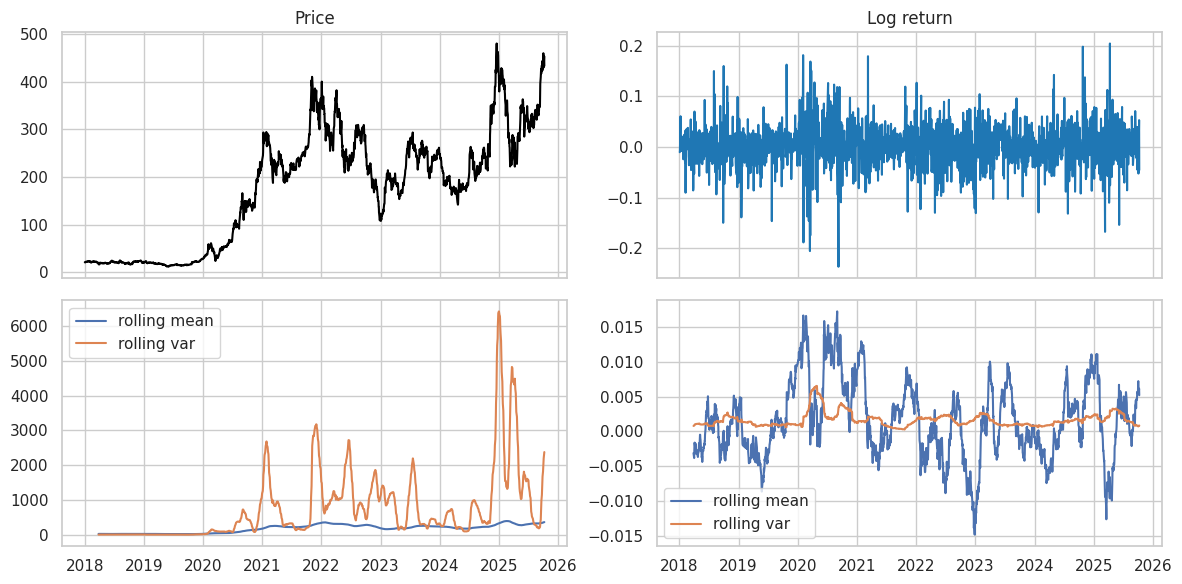

In [4]:
# -------------------------------
# 2) 롤링 평균/분산으로 직관 확인
# -------------------------------
def rolling_mean_var(s, win=60):
    return s.rolling(win).mean(), s.rolling(win).var()

m_p, v_p = rolling_mean_var(y_price, 60)
m_r, v_r = rolling_mean_var(ret, 60)

fig, ax = plt.subplots(2,2, figsize=(12,6), sharex='col')
ax[0,0].plot(y_price, color="black"); ax[0,0].set_title("Price")
ax[1,0].plot(m_p, label="rolling mean"); ax[1,0].plot(v_p, label="rolling var"); ax[1,0].legend()
ax[0,1].plot(ret, color="tab:blue"); ax[0,1].set_title("Log return")
ax[1,1].plot(m_r, label="rolling mean"); ax[1,1].plot(v_r, label="rolling var"); ax[1,1].legend()
plt.tight_layout(); plt.show()


## 3) ACF/PACF 그래프

* `plot_acf(y, lags=…)`, `plot_pacf(y, lags=…, method="ywm")`

  * ACF: 전체 자기상관
  * PACF: 중간 시차의 효과를 제거한 “직접” 자기상관
* 해석 포인트:

  * 가격 시계열은 **강한 양의 자기상관**(천천히 감쇠).
  * 수익률은 대부분 **빠르게 0으로 수렴**(랜덤워크 가정과 부합).


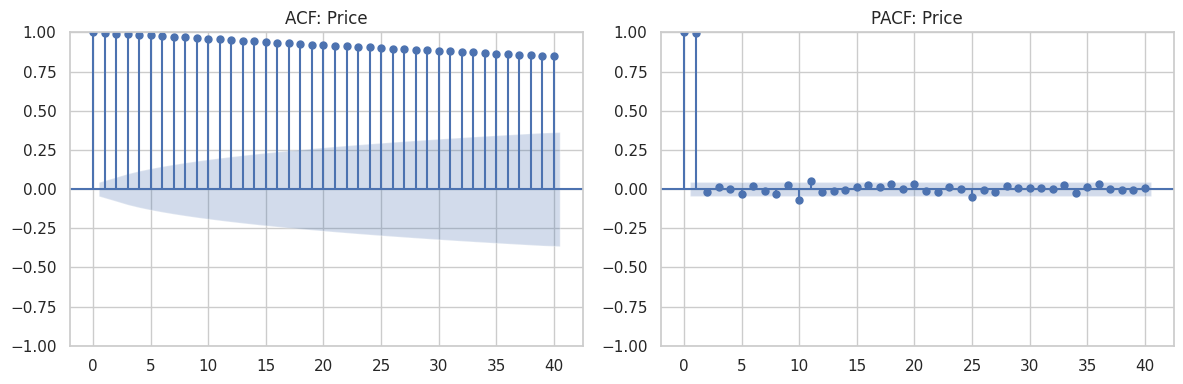

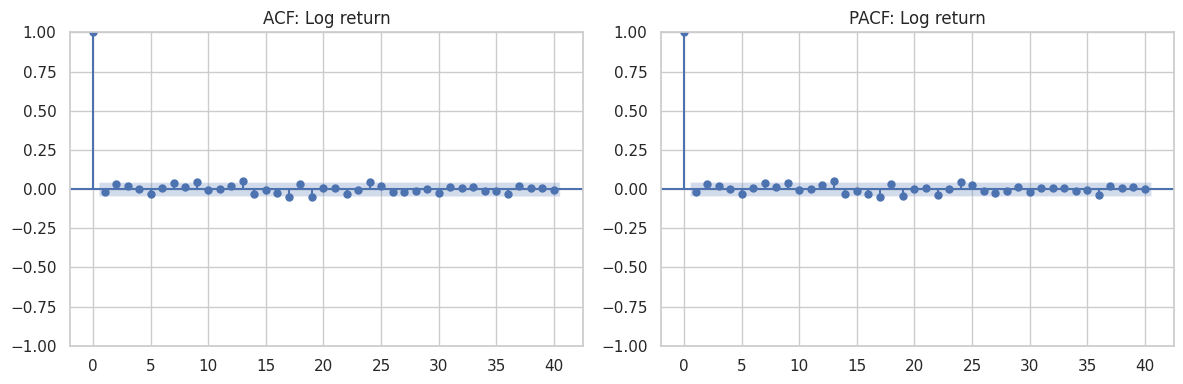

In [5]:
# -------------------------------
# 3) ACF / PACF
# -------------------------------
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(y_price.dropna(), lags=40, ax=ax[0]); ax[0].set_title("ACF: Price")
plot_pacf(y_price.dropna(), lags=40, ax=ax[1], method="ywm"); ax[1].set_title("PACF: Price")
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(ret, lags=40, ax=ax[0]); ax[0].set_title("ACF: Log return")
plot_pacf(ret, lags=40, ax=ax[1], method="ywm"); ax[1].set_title("PACF: Log return")
plt.tight_layout(); plt.show()

## 4) 단위근/정상성 검정 (ADF & KPSS)

* **ADF (Augmented Dickey–Fuller)**

  * 귀무가설 H₀: 단위근 존재(비정상, random walk)
  * p-value가 작으면(예: < 0.05) H₀ 기각 → **정상성**
  * 일반적으로: **가격은 기각 못함(비정상), 수익률은 기각(정상)**
* **KPSS (Kwiatkowski–Phillips–Schmidt–Shin)**

  * 귀무가설 H₀: (추세)정상
  * p-value가 작으면 H₀ 기각 → **비정상**
  * ADF와 **상보적** 관계로 같이 봅니다.
* 코드에서는 두 검정을 **가격/수익률 각각**에 대해 수행해 결과표(p-value, test stat, 결론)를 출력합니다.

## 4) Ljung–Box 잔차 독립성(자기상관 없음) 검정

* 귀무가설 H₀: “시차 k까지 자기상관이 없다(백색잡음)”
* 관행:

  * **가격**: 보통 H₀ 기각(자기상관 존재) → 비정상적 구조
  * **수익률**: 보통 H₀ 기각 못함(자기상관 미약) → 백색잡음 근사
* 코드 포인트:

  * 가격과 수익률을 **따로따로** 검정합니다(두 시계열의 통계적 성질이 다르므로).
  * `lb_p < 0.05`이면 “유의: 자기상관 있음” / 그렇지 않으면 “유의하지 않음: 자기상관 증거 부족”을 **문장으로 함께 출력**합니다.

In [6]:
# -------------------------------
# 4) 정상성 검정 함수 (ADF, KPSS) + 해석 문구
# -------------------------------
def adf_kpss_report(s, name, kpss_reg="c"):
    out = {}

    # ADF
    try:
        adf_stat, adf_p, usedlag, nobs, crit, icbest = adfuller(s.dropna(), autolag="AIC")
        out.update({"ADF_stat":adf_stat, "ADF_p":adf_p})
    except Exception as e:
        out.update({"ADF_stat":np.nan, "ADF_p":np.nan})

    # KPSS (level: 'c', trend: 'ct')
    try:
        kpss_stat, kpss_p, lags, crit = kpss(s.dropna(), regression=kpss_reg, nlags="auto")
        out.update({"KPSS_stat":kpss_stat, "KPSS_p":kpss_p, "KPSS_reg":kpss_reg})
    except Exception as e:
        out.update({"KPSS_stat":np.nan, "KPSS_p":np.nan, "KPSS_reg":kpss_reg})

    # 간단 해석
    adf_dec  = "정상성(ADF: H0=단위근 기각)" if out["ADF_p"]<0.05 else "비정상(ADF: H0 기각 못함)"
    kpss_dec = "정상성 유지(KPSS: H0 기각 못함)" if out["KPSS_p"]>0.05 else "비정상(KPSS: H0=정상성 기각)"

    return pd.Series(out|{"Series":name, "ADF_decision":adf_dec, "KPSS_decision":kpss_dec})

tbl = pd.concat([
    adf_kpss_report(y_price, "Price", "ct"),   # 가격은 추세가 있을 수 있어 trend 포함
    adf_kpss_report(y_log,   "Log Price", "ct"),
    adf_kpss_report(ret,     "Log Return", "c"),
], axis=1).T[["Series","ADF_stat","ADF_p","ADF_decision","KPSS_stat","KPSS_p","KPSS_reg","KPSS_decision"]]

print("\n=== Stationarity tests on TSLA ===")
display(tbl)


=== Stationarity tests on TSLA ===


,Series,ADF_stat,ADF_p,ADF_decision,KPSS_stat,KPSS_p,KPSS_reg,KPSS_decision
0,Price,-1.341152,0.610141,비정상(ADF: H0 기각 못함),0.648846,0.01,ct,비정상(KPSS: H0=정상성 기각)
1,Log Price,-1.000252,0.753172,비정상(ADF: H0 기각 못함),1.182544,0.01,ct,비정상(KPSS: H0=정상성 기각)
2,Log Return,-44.850255,0.0,정상성(ADF: H0=단위근 기각),0.128956,0.1,c,정상성 유지(KPSS: H0 기각 못함)


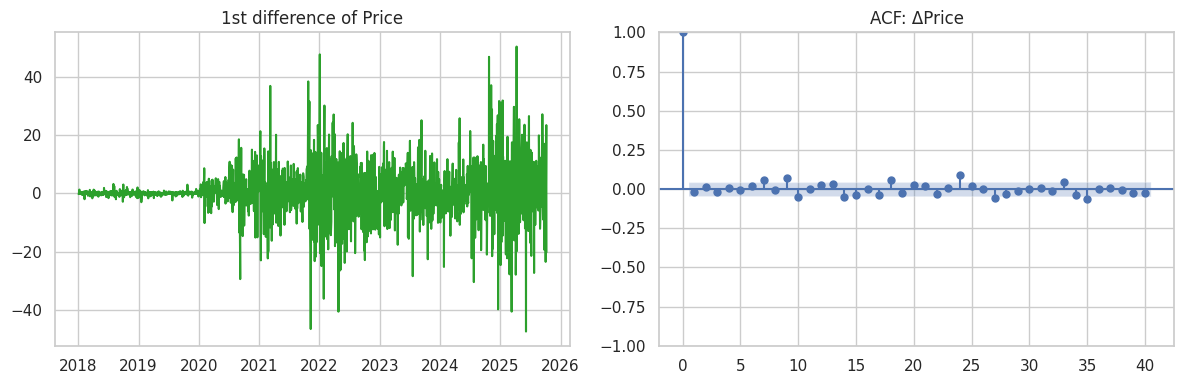


ADF/KPSS on ΔPrice


,ADF_stat,ADF_p,KPSS_stat,KPSS_p,KPSS_reg,Series,ADF_decision,KPSS_decision
0,-7.73882,0.0,0.062782,0.1,c,ΔPrice,정상성(ADF: H0=단위근 기각),정상성 유지(KPSS: H0 기각 못함)


In [7]:
# -------------------------------
# 5) 차분(differencing)으로 정상성 유도
# -------------------------------
d1 = y_price.diff().dropna().rename("price_diff1")
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(d1, color="tab:green"); ax[0].set_title("1st difference of Price")
plot_acf(d1, lags=40, ax=ax[1]); ax[1].set_title("ACF: ΔPrice")
plt.tight_layout(); plt.show()

print("\nADF/KPSS on ΔPrice")
display(adf_kpss_report(d1, "ΔPrice", "c").to_frame().T)

## 6) 강정상성 약 정상성

* **강정상성**: 모든 차원/시점에서 결합분포가 시간 평행이동에 불변.
* **약정상성**(2계 정상성): 평균/분산이 시간에 의존하지 않고, 공분산이 **시차**에만 의존.
* 코드에선:

  * (a) **정상 모형** 예시: white noise 또는 ARMA로 생성 → 롤링 평균/분산이 안정, ADF 통과
  * (b) **비정상 모형** 예시: 누적합(랜덤워크) 또는 추세+노이즈 → 평균 추세/분산 증가, ADF 기각 못함
  * 그래프와 함께 특성을 직관적으로 비교합니다.

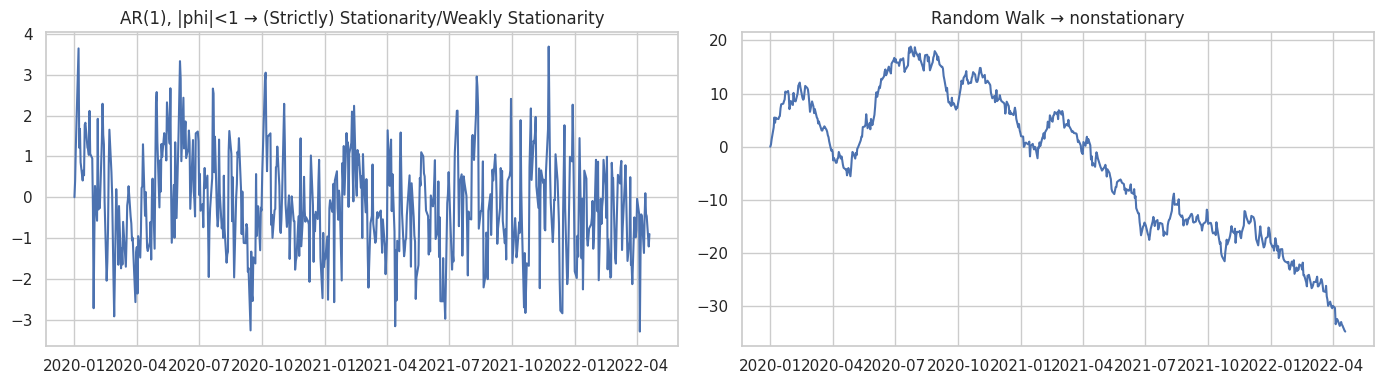

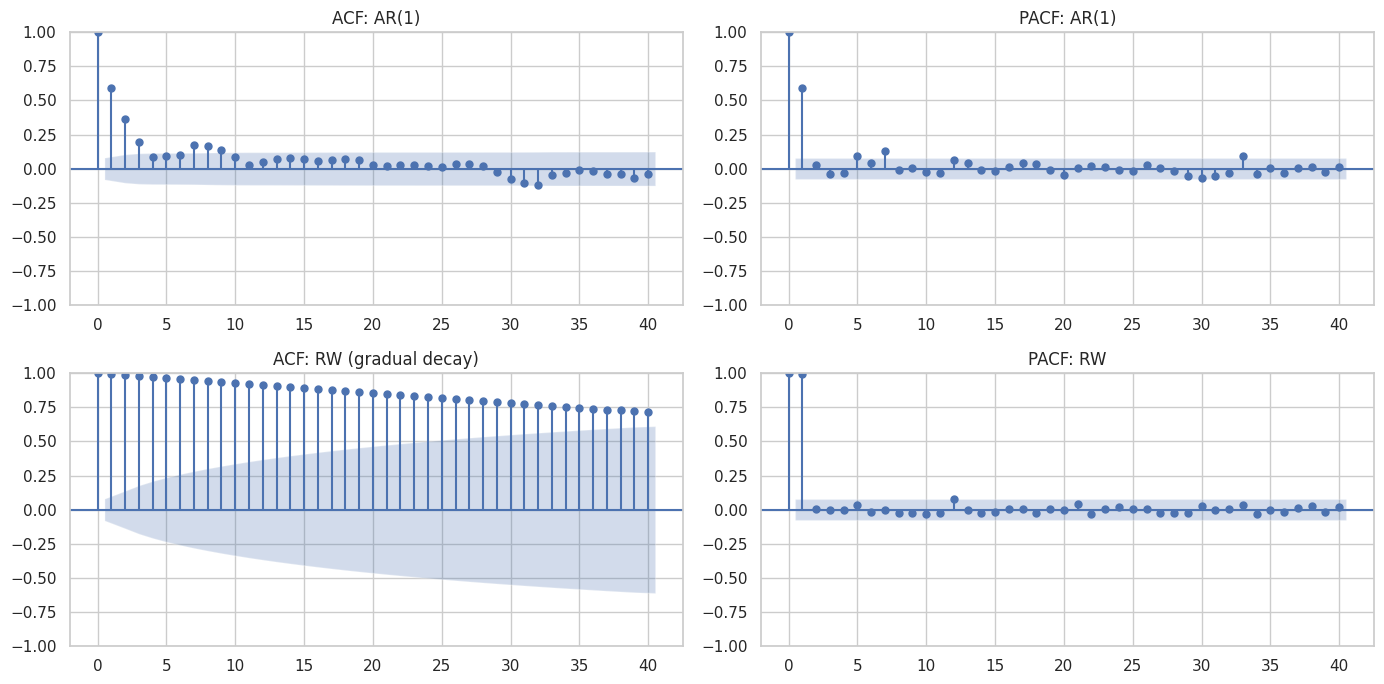


=== ADF/KPSS on synthetic ===


,ADF_stat,ADF_p,KPSS_stat,KPSS_p,KPSS_reg,Series,ADF_decision,KPSS_decision
0,-6.440385,0.0,0.462862,0.050059,c,AR(1),정상성(ADF: H0=단위근 기각),정상성 유지(KPSS: H0 기각 못함)
1,0.514902,0.985319,0.536887,0.01,ct,Random Walk,비정상(ADF: H0 기각 못함),비정상(KPSS: H0=정상성 기각)


In [22]:
# -------------------------------
# 6) 정상 vs 비정상: 모의 데이터로 확실한 대비
# -------------------------------
np.random.seed(0)
n = 600
eps = np.random.normal(0,1,n)

# (a) 정상 AR(1)
phi = 0.6
x = np.zeros(n)
for t in range(1,n):
    x[t] = phi*x[t-1] + eps[t]
x = pd.Series(x, index=pd.date_range("2020-01-01", periods=n, freq="B"), name="AR1_stationary")

# (b) 비정상 Random walk
rw = np.zeros(n)
for t in range(1,n):
    rw[t] = rw[t-1] + eps[t]
rw = pd.Series(rw, index=x.index, name="RandomWalk_nonstationary")

fig, ax = plt.subplots(1,2, figsize=(14,4))
ax[0].plot(x);  ax[0].set_title("AR(1), |phi|<1 → (Strictly) Stationarity/Weakly Stationarity")
ax[1].plot(rw); ax[1].set_title("Random Walk → nonstationary")
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(2,2, figsize=(14,7))
plot_acf(x,  lags=40, ax=ax[0,0]); ax[0,0].set_title("ACF: AR(1)")
plot_pacf(x, lags=40, ax=ax[0,1], method="ywm"); ax[0,1].set_title("PACF: AR(1)")
plot_acf(rw,  lags=40, ax=ax[1,0]); ax[1,0].set_title("ACF: RW (gradual decay)")
plot_pacf(rw, lags=40, ax=ax[1,1], method="ywm"); ax[1,1].set_title("PACF: RW")
plt.tight_layout(); plt.show()

print("\n=== ADF/KPSS on synthetic ===")
display(pd.concat([
    adf_kpss_report(x,  "AR(1)", "c"),
    adf_kpss_report(rw, "Random Walk", "ct"),
], axis=1).T)

등분산(Homoscedastic) 잡음 이분산(Heteroscedastic) 잡음


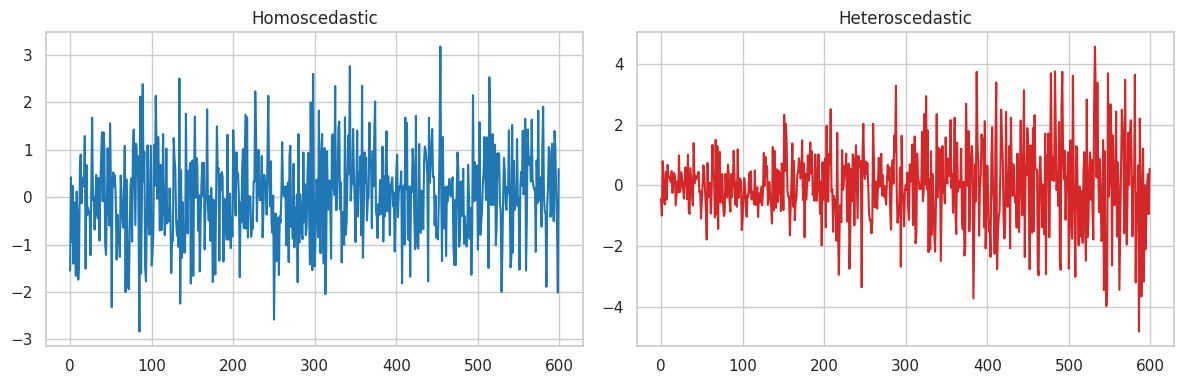

In [23]:
# -------------------------------
# 7) 등분산성(잔차 분산 일정) 비교 예시
#    - 동일 분산 vs 시간 가변 분산(GARCH 풍) 모의 데이터
# -------------------------------
# 등분산
e1 = np.random.normal(0,1,n)
# 시변 분산(단순한 ARCH-like): 분산이 느리게 변하도록 설계
vol = np.linspace(0.5, 2.0, n)
e2 = np.random.normal(0,vol,n)

fig, ax = plt.subplots(1,2, figsize=(12,4))
print("등분산(Homoscedastic) 잡음","이분산(Heteroscedastic) 잡음")
ax[0].plot(e1, color="tab:blue"); ax[0].set_title("Homoscedastic")
ax[1].plot(e2, color="tab:red");  ax[1].set_title("Heteroscedastic")
plt.tight_layout(); plt.show()



요약:
- TSLA '가격'은 보통 비정상(추세/분산변동) → ADF p↑, KPSS p↓ 경향.
- TSLA '로그수익률'은 대체로 정상(평균≈0, 분산 일정 가정) → ADF p↓, KPSS p↑ 경향.
- 필요 시 차분(ΔPrice)로 정상성에 더 가까워짐.
- 엄밀한 '강 정상성'은 분포 자체가 시간 이동에 대해 불변이어야 함(AR(1)+iid 정규잡음이면 충족).
- 등분산성은 잔차의 분산 일정 여부로, 정상성과 함께 모델 진단에 중요.

## * 왜 “가격” 대신 “수익률”로 모델링하나?

* 가격은 대개 **랜덤워크** 성향(단위근) → 비정상.
* 로그수익률은 **약정상성**을 만족하는 경우가 많아 예측/추정 가정에 유리.
* ARIMA/SARIMA/VAR/ARCH류 대부분이 **정상성(약정상성) 기반** 가정을 사용.

## * 자주 생기는 이슈 & 해결

* **yfinance 컬럼 타입**: `px["Close"]`가 DataFrame으로 남아 `rename("…")`에서 TypeError → `squeeze("columns")`로 **Series 강제**.
* **표본 길이**: ACF/PACF/검정에서 `lags`를 너무 크게 잡으면 신뢰구간이 넓어져 해석이 어려움 → 관측치의 `~min(40, N/4)` 정도 권장.
* **검정 다중성**: 여러 래그/검정을 동시에 보면 우연한 유의가 나올 수 있음 → 실무에선 보수적으로 해석.

## * 결과 읽는 법(요약)

* **가격**: ADF p-value ↑, KPSS p-value ↓, Ljung–Box p-value ↓ → “비정상 & 자기상관 존재”
* **수익률**: ADF p-value ↓, KPSS p-value ↑, Ljung–Box p-value ↑ → “(약)정상 & 자기상관 없음(백색잡음 근사)”

